In [1]:
%matplotlib inline
#from typing import Dict, Tuple, List, Union, Iterable

import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
#from matplotlib.ticker import AutoMinorLocator
plt.style.use("lm")
import numpy as np
#import scipy.linalg as sl #expm
#import os
#import time
#import random
#import string
#import copy
#from tabulate import tabulate
import samplebase as sb

import path_utils as putils

In [2]:
from decimal import Decimal

def fexp(number):
    (sign, digits, exponent) = Decimal(number).as_tuple()
    return len(digits) + exponent - 1

def fman(number):
    return Decimal(number).scaleb(-fexp(number)).normalize()

def to_latex_value_with_err(value, err, n_round=1, include_math_env=False):
    assert abs(value) > abs(err)
    val_exp = fexp(value)
    err_2 = err / (10**val_exp)
    n_round = max(-1*fexp(err_2),n_round)
    err_man = round(err_2, n_round)
    val_man = round(fman(value), n_round)
    val_str = ("{:0." + str(n_round) + "f}").format(val_man)
    err_str = ("{:0." + str(n_round) + "f}").format(err_man)
    if val_exp==0:
        result = val_str + " \pm " + err_str
    else:
        result = r"( " + val_str + " \pm " + err_str + r")\times 10^" + "{" + str(val_exp) +"}"
    if include_math_env:
        result = r"$ " + result + r" $"
    return result

def to_latex_value(value, n_round=1, include_math_env=False):
    val_exp = fexp(value)
    val_man = round(fman(value), n_round)
    val_str = ("{:0." + str(n_round) + "f}").format(val_man)
    if val_exp==0:
        result = val_str
    else:
        result = val_str + r"\times 10^" + "{" + str(val_exp) +"} "
    
    if include_math_env:
        result = r"$ " + result + r" $"
    return result

print(to_latex_value_with_err(1e-3, 0.5e-6))
print(to_latex_value(4e-3))
print(to_latex_value_with_err(1e-3, 0.5e-6, include_math_env=True))
print(to_latex_value(4e-3, include_math_env=True))
print(to_latex_value(1.3))
print(to_latex_value_with_err(1.2, 1.1))

( 1.0000 \pm 0.0005)\times 10^{-3}
4.0\times 10^{-3} 
$ ( 1.0000 \pm 0.0005)\times 10^{-3} $
$ 4.0\times 10^{-3}  $
1.3
1.2 \pm 1.1


In [3]:
def cluster_along_arg(samples, arg_key, arg_values):
    """
    Transform list of samples into a dictionary that maps 
    from arg_value (described by arg_key) to the clustered 
    samples list.
    """
    clustered_samples = dict()
    for arg_value in arg_values:
        clustered_samples[arg_value] = []
    
    for sample in samples:
        for arg_value in arg_values:
            if sample.args[arg_key] == arg_value:
                clustered_samples[arg_value].append(sample)
    
    return clustered_samples

In [4]:
def plot_overview(plot_functions, n_rows=1, n_cols=3, size_factor=1.):
    plt.figure(1, figsize=(5*n_cols*size_factor,3.6*n_rows*size_factor))
    n_plots = n_rows * n_cols
    idx = 1
    for pf in plot_functions:
        if idx > n_plots:
            break
        plt.subplot(n_rows, n_cols, idx)
        #plt.xscale("log")
        #secondrow = (idx in [7,8,9,10,11,12]) or (idx in [19,20,21,22,23,24]) or (idx in [31,32,33,34,35,36])
        #if secondrow:
        #    plt.gca().set_axis_bgcolor('#ededed')
        pf()
        idx += 1

    plt.subplots_adjust(top=0.96, bottom=0.04, left=0.07, right=0.97, hspace=0.4, wspace=0.35)
    #plt.tight_layout(pad=0.6, w_pad=2.0, h_pad=2.0)

In [5]:
data_dir = putils.data_dir(16)
data_dir

'/srv/public/workspace/data/rlearn-16'

In [6]:
all_samples = sb.list_of_samples(data_dir)
n_done = sum([1 for s in all_samples if s.done])
n_total = len(all_samples)
print(n_done, "/", n_total)

700 / 700


In [7]:
done_samples = [s for s in all_samples if s.done]

In [8]:
done_samples[0].args

{'alpha': array([1.00000000e-08, 1.32571137e-08, 1.75751062e-08, 2.32995181e-08,
        3.08884360e-08, 4.09491506e-08, 5.42867544e-08, 7.19685673e-08,
        9.54095476e-08, 1.26485522e-07]),
 'gillespie_realisations': 10000,
 'iid_id': 8,
 'n_splits': 5,
 'traj_file_path': './gillespie_trajs.h5'}

In [9]:
done_samples[0].result["cv_result"][0]

{'alpha': 1e-08,
 'cutoff': 0.0,
 'l1_ratio': 1.0,
 'score': [-6.554444149968272,
  -0.0003870075646834833,
  -0.00042018319449659117,
  -0.000373379062028395,
  -0.0004171391728518572]}

In [10]:
# get cv_result for every alpha, gill_real, iid
cv_results = []
# each data row (cv for one alpha, gill_real, id) has the form
example_element = {"alpha": 1e-6, "gillespie_realisations": 100, "iid": 0, "scores": [1.,2.,3.,4.,5.]}
for ds in done_samples:
    for alpha_idx, current_alpha in enumerate(ds.args["alpha"]):
        element = {
            "alpha": current_alpha, 
            "gillespie_realisations": ds.args["gillespie_realisations"], 
            "iid": ds.args["iid_id"], 
            "scores": np.array(ds.result["cv_result"][alpha_idx]["score"])}
        cv_results.append(element)

In [11]:
import pandas as pd

In [12]:
cv_results = pd.DataFrame(cv_results)

In [13]:
alphas = set()
timesteps = set()
noises = set()
folds = set()
iids = set()
gillespie_realisations = set()
for s in all_samples:
    if s.done:
        #alphas.add(s.args["alpha"])
        #timesteps.add(s.args["dt"])
        #noises.add(s.args["noise"])
        folds.add(s.args["n_splits"])
        gillespie_realisations.add(s.args["gillespie_realisations"])
        iids.add(s.args["iid_id"])
#alphas = np.fromiter(alphas, dtype=float)
#alphas.sort()
alphas = np.logspace(-8, -2, num=50)
timesteps = np.fromiter(timesteps, dtype=float)
timesteps.sort()
noises = np.fromiter(noises, dtype=float)
noises.sort()
folds = np.fromiter(folds, dtype=int)
folds.sort()
gillespie_realisations = np.fromiter(gillespie_realisations, dtype=int)
gillespie_realisations.sort()
iids = np.fromiter(iids, dtype=int)
iids.sort()
print(alphas)
print(timesteps)
print(noises)
print(folds)
print(gillespie_realisations)
print(iids)

[1.00000000e-08 1.32571137e-08 1.75751062e-08 2.32995181e-08
 3.08884360e-08 4.09491506e-08 5.42867544e-08 7.19685673e-08
 9.54095476e-08 1.26485522e-07 1.67683294e-07 2.22299648e-07
 2.94705170e-07 3.90693994e-07 5.17947468e-07 6.86648845e-07
 9.10298178e-07 1.20679264e-06 1.59985872e-06 2.12095089e-06
 2.81176870e-06 3.72759372e-06 4.94171336e-06 6.55128557e-06
 8.68511374e-06 1.15139540e-05 1.52641797e-05 2.02358965e-05
 2.68269580e-05 3.55648031e-05 4.71486636e-05 6.25055193e-05
 8.28642773e-05 1.09854114e-04 1.45634848e-04 1.93069773e-04
 2.55954792e-04 3.39322177e-04 4.49843267e-04 5.96362332e-04
 7.90604321e-04 1.04811313e-03 1.38949549e-03 1.84206997e-03
 2.44205309e-03 3.23745754e-03 4.29193426e-03 5.68986603e-03
 7.54312006e-03 1.00000000e-02]
[]
[]
[5]
[    1     2     5    10    20    50   100   200   500  1000  2000  5000
 10000 20000]
[0 1 2 3 4 5 6 7 8 9]


In [14]:
if False:
    samples = cluster_along_arg(done_samples, "gillespie_realisations", gillespie_realisations)
    for g in gillespie_realisations:
        samples[g] = cluster_along_arg(samples[g], "n_splits", folds)

In [15]:
def plot_validation(sample_list, mean=True, exclude_first_fold=True):
    #sorted_samples = sorted(sample_list, key=lambda x: x.args["alpha"])
    alpha_lower = 1e-9
    alpha_upper = 1e-2
    #sorted_samples = [s for s in sorted_samples if alpha_lower < s.args["alpha"] < alpha_upper ]
    #scores = np.array([ np.array(s.result["cv_result"][0]["score"]) for s in sorted_samples])
    #print(scores)
    alphas = []
    scores = []
    for s in sample_list:
        for result in s.result["cv_result"]:
            alphas.append(result["alpha"])
            scores.append(result["score"])
    alphas = np.array(alphas)
    scores = np.array(scores)
    n_samples = len(scores[0])
    #scores = np.mean(scores, axis=1)
    min_indices = np.argmin(-scores)
    #alphas = np.array([ s.args["alpha"] for s in sorted_samples])
    if mean:
        if exclude_first_fold:
            exclude_first = scores[:, 1:]
            mean_scores = np.mean(exclude_first, axis=1)
            err_scores = np.std(exclude_first, axis=1) / np.sqrt(n_samples-1 if n_samples>2 else 1)
        else:
            mean_scores = np.mean(scores, axis=1)
            err_scores = np.std(scores, axis=1) / np.sqrt(n_samples if n_samples>2 else 1)
        plt.errorbar(alphas, - mean_scores, yerr=err_scores, fmt=".")
        print("best mean score for alpha={}".format(alphas[np.argmin(-mean_scores)]))
    else:
        start_at = 1 if exclude_first_fold else 0
        for i in range(start_at, n_folds):
            #if i < 7:
            plt.plot(alphas, - scores[:,i], ".", label=str(i))
    plt.legend()
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(r"$\alpha$")
    plt.ylabel("score")
    
def plot_trajs(sample_list, mean=True):
    sorted_samples = sorted(sample_list, key=lambda x: x.args["alpha"])
    traj_counts = [ s.result["counts"] for s in sorted_samples ]
    for counts in traj_counts[1:2]:
        plt.plot(counts, alpha=1.0)

In [16]:
n_folds=5
hyperparam_for_realisation = dict()

def plot_validation_pd(cv_results_for_g : pd.DataFrame, exclude_first_fold=True, mean=False, n_real=0):
    scores_for_alpha = []
    errs_for_alpha = []
    for a in alphas:
        slice_alpha = cv_results_for_g[cv_results_for_g.alpha == a]
        all_scores = np.array([x for x in slice_alpha.scores.values])
        #print(all_scores)
        if exclude_first_fold:
            scores = all_scores[:,1:]
        else:
            scores = all_scores
        
        if mean:
            # average over folds and iids
            n = scores.size
            mean_score = np.mean(scores)
            err_score = np.std(scores) / np.sqrt(n)
        else:
            # only average over iids
            n = scores.shape[0]
            mean_score = np.mean(scores, axis=0)
            err_score = np.std(scores, axis=0) / np.sqrt(n)
        
        scores_for_alpha.append(mean_score)
        errs_for_alpha.append(err_score)
    
    scores_for_alpha = np.array([x for x in scores_for_alpha])
    errs_for_alpha = np.array([x for x in errs_for_alpha])
    print(errs_for_alpha.shape)
    #if mean:
    min_indices = np.argmin(-scores_for_alpha, axis=0)
    #else:
    #    min_indices = 
    min_alpha = alphas[min_indices]
    print("n_real", n_real, "min_alpha", min_alpha)
    if mean:
        plt.errorbar(alphas, -scores_for_alpha, yerr=errs_for_alpha)
    else:
        for i in range(n_folds - 1 if exclude_first_fold else n_folds):
            plt.errorbar(alphas, -scores_for_alpha[:, i], yerr=errs_for_alpha[:,i],
                         label="fold "+str(i + 1 if exclude_first_fold else i))
    plt.legend()
    plt.title(r"$n_\mathrm{real}=" + str(n_real) + r"$, $\alpha_\mathrm{min}=$" + str(min_alpha if mean else ""))
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(r"$\alpha$")
    plt.ylabel("score")
    
    if mean:
        hyperparam_for_realisation[n_real] = min_alpha

In [17]:
pfs = []
for g in gillespie_realisations:
    cv_results_g = cv_results[cv_results.gillespie_realisations == g]
    #plot_validation_pd(cv_results_g, exclude_first_score=True, mean=True)
    pfs.append(lambda df=cv_results_g, _g=g: plot_validation_pd(df, mean=True, exclude_first_fold=True, n_real=_g))

[samplebase] [2018-05-23 11:33:05] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-05-23 11:33:05] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-05-23 11:33:05] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-05-23 11:33:05] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-05-23 11:33:05] [WARNING] No handles with labels found to put in legend.


(50,)
n_real 1 min_alpha 0.00323745754281764
(50,)
n_real 2 min_alpha 0.0018420699693267163
(50,)
n_real 5 min_alpha 0.00010985411419875573
(50,)
n_real 10 min_alpha 0.00025595479226995333
(50,)
n_real 20 min_alpha 0.00025595479226995333


[samplebase] [2018-05-23 11:33:05] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-05-23 11:33:05] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-05-23 11:33:05] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-05-23 11:33:05] [WARNING] No handles with labels found to put in legend.


(50,)
n_real 50 min_alpha 4.71486636345739e-05
(50,)
n_real 100 min_alpha 3.5564803062231284e-05
(50,)
n_real 200 min_alpha 1.1513953993264481e-05
(50,)
n_real 500 min_alpha 6.5512855685955095e-06


[samplebase] [2018-05-23 11:33:05] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-05-23 11:33:05] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-05-23 11:33:05] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-05-23 11:33:05] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-05-23 11:33:05] [WARNING] No handles with labels found to put in legend.


(50,)
n_real 1000 min_alpha 2.1209508879201924e-06
(50,)
n_real 2000 min_alpha 2.811768697974231e-06
(50,)
n_real 5000 min_alpha 2.1209508879201924e-06
(50,)
n_real 10000 min_alpha 1.5998587196060574e-06
(50,)
n_real 20000 min_alpha 2.811768697974231e-06


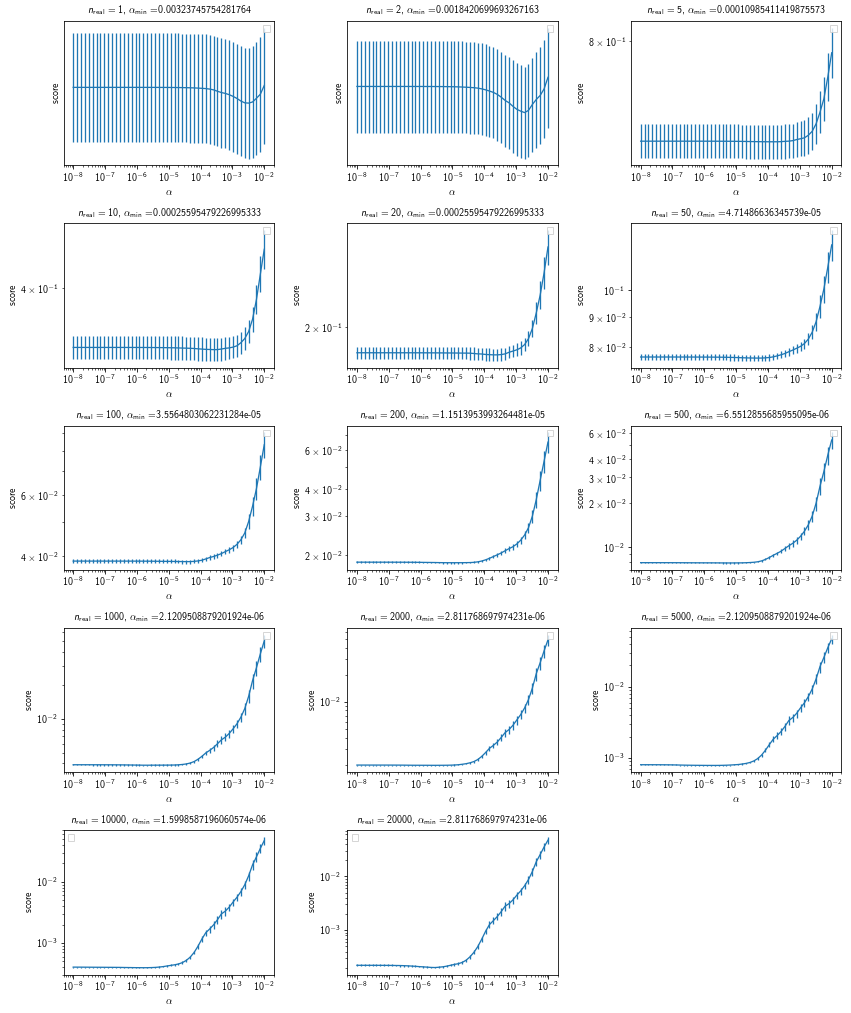

In [18]:
plot_overview(pfs, n_rows=5, n_cols=3, size_factor=0.8)
#plt.savefig("cv_gill_kfold_scale500_singlefolds_all_folds.pdf", bbox_inches="tight", transparent=True)

Text(0,0.5,'hyperparameter found by kfold')

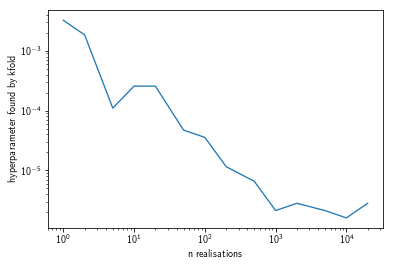

In [19]:
plt.plot([x for x in hyperparam_for_realisation.keys()], [x for x in hyperparam_for_realisation.values()])
plt.xscale("log")
plt.yscale("log")
plt.xlabel("n realisations")
plt.ylabel("hyperparameter found by kfold")

In [20]:
if False:
    import pickle
    with open("hyperparam.pickle", "wb") as f:
        pickle.dump(hyperparam_for_realisation, f)

In [21]:
if False:
    import pickle
    with open("hyperparam.pickle", "rb") as f:
        hyperparam_for_realisation = pickle.load(f)

## l1 vs n_real
For each $n_\mathrm{real}$ and $iid$ solve the system and compare the according estimated rates with the desired rates.

In [22]:
import run_cv as rs

/srv/public/miniconda3/envs/rlearn/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [23]:
dt = 3e-3
target_time = 2.
use_n_folds = 5 # only use the last as test-set

In [24]:
# get desired rates
regulation_network, analysis = rs.get_regulation_network(dt, 0.0, target_time, gillespie_realisations=None, scale=1.)
desired_rates = regulation_network.desired_rates

obtaining regulation network with dt = 0.003
generating data by integrating the law of mass action with additive lma_noise 0.0
0.003
0.003


In [26]:
import time

(g,i)=(1,0) ...
find hyperparameter


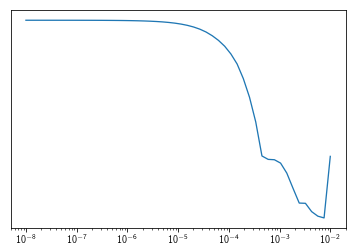

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.0075431200633546075, lambda=1.0)!
status 0: Optimization terminated successfully.
131 / 30000 iterations
applying cutoff
... took 18.39049236406572 seconds
(g,i)=(1,1) ...
find hyperparameter


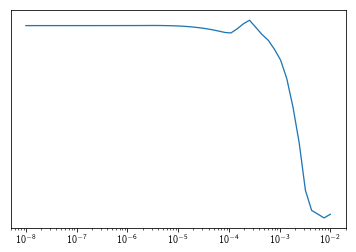

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.0075431200633546075, lambda=1.0)!
status 0: Optimization terminated successfully.
114 / 30000 iterations
applying cutoff
... took 16.201558097964153 seconds
(g,i)=(1,2) ...
find hyperparameter


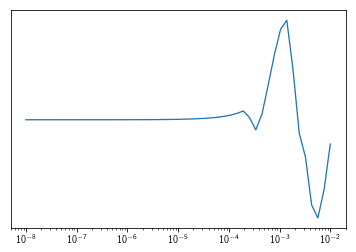

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.005689866029018293, lambda=1.0)!
status 0: Optimization terminated successfully.
172 / 30000 iterations
applying cutoff
... took 22.704592255991884 seconds
(g,i)=(1,3) ...
find hyperparameter


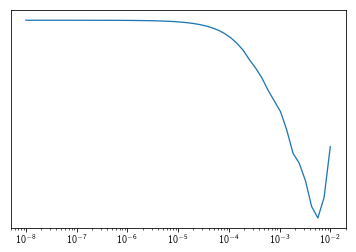

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.005689866029018293, lambda=1.0)!
status 0: Optimization terminated successfully.
132 / 30000 iterations
applying cutoff
... took 18.219243271974847 seconds
(g,i)=(1,4) ...
find hyperparameter


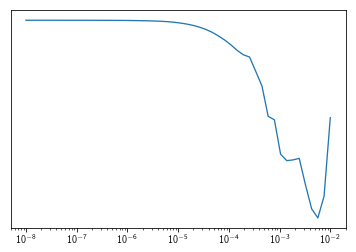

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.005689866029018293, lambda=1.0)!
status 0: Optimization terminated successfully.
124 / 30000 iterations
applying cutoff
... took 16.665479104965925 seconds
(g,i)=(1,5) ...
find hyperparameter


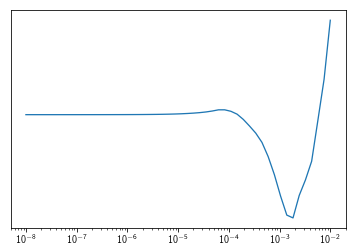

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.0018420699693267163, lambda=1.0)!
status 0: Optimization terminated successfully.
168 / 30000 iterations
applying cutoff
... took 22.003818697994575 seconds
(g,i)=(1,6) ...
find hyperparameter


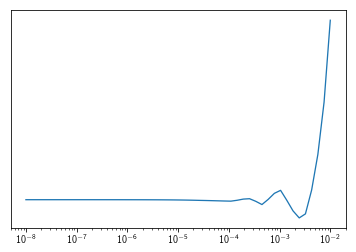

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.0024420530945486497, lambda=1.0)!
status 0: Optimization terminated successfully.
165 / 30000 iterations
applying cutoff
... took 21.784118324983865 seconds
(g,i)=(1,7) ...
find hyperparameter


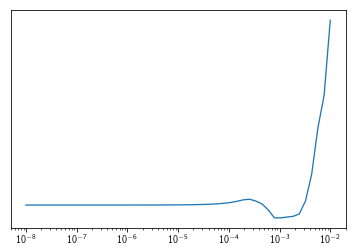

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.0010481131341546852, lambda=1.0)!
status 0: Optimization terminated successfully.
174 / 30000 iterations
applying cutoff
... took 22.370427362970077 seconds
(g,i)=(1,8) ...
find hyperparameter


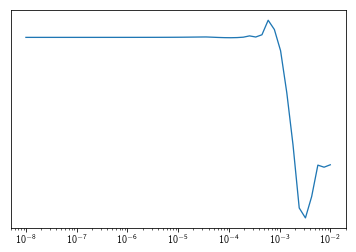

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.00323745754281764, lambda=1.0)!
status 0: Optimization terminated successfully.
137 / 30000 iterations
applying cutoff
... took 18.324806352960877 seconds
(g,i)=(1,9) ...
find hyperparameter


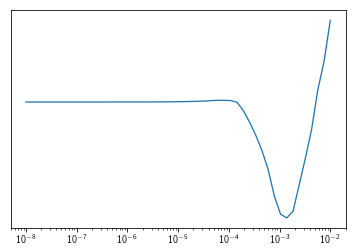

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.001389495494373136, lambda=1.0)!
status 0: Optimization terminated successfully.
183 / 30000 iterations
applying cutoff
... took 23.940511954016984 seconds
(g,i)=(2,0) ...
find hyperparameter


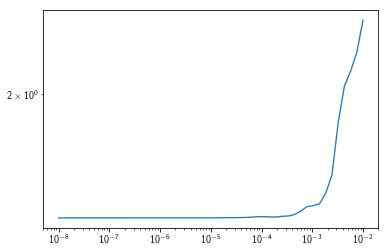

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
248 / 30000 iterations
applying cutoff
... took 32.02197916607838 seconds
(g,i)=(2,1) ...
find hyperparameter


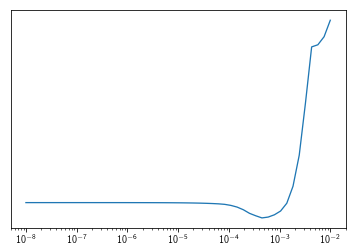

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.0004498432668969444, lambda=1.0)!
status 0: Optimization terminated successfully.
236 / 30000 iterations
applying cutoff
... took 30.55001038010232 seconds
(g,i)=(2,2) ...
find hyperparameter


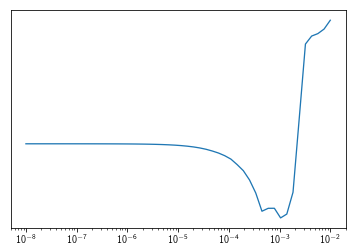

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.0010481131341546852, lambda=1.0)!
status 0: Optimization terminated successfully.
215 / 30000 iterations
applying cutoff
... took 27.85774340701755 seconds
(g,i)=(2,3) ...
find hyperparameter


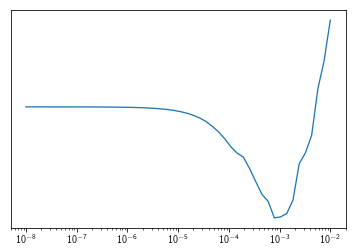

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.0007906043210907702, lambda=1.0)!
status 0: Optimization terminated successfully.
213 / 30000 iterations
applying cutoff
... took 27.427220419980586 seconds
(g,i)=(2,4) ...
find hyperparameter


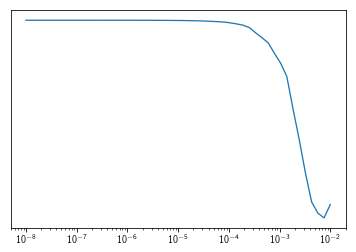

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.0075431200633546075, lambda=1.0)!
status 0: Optimization terminated successfully.
120 / 30000 iterations
applying cutoff
... took 16.30303263408132 seconds
(g,i)=(2,5) ...
find hyperparameter


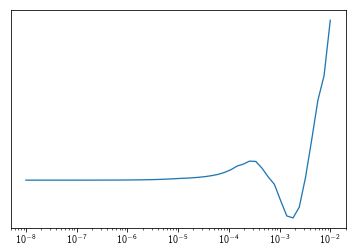

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.0018420699693267163, lambda=1.0)!
status 0: Optimization terminated successfully.
178 / 30000 iterations
applying cutoff
... took 23.16078350401949 seconds
(g,i)=(2,6) ...
find hyperparameter


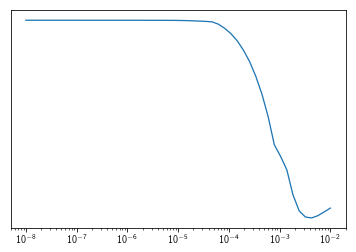

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.004291934260128779, lambda=1.0)!
status 0: Optimization terminated successfully.
168 / 30000 iterations
applying cutoff
... took 23.022320530959405 seconds
(g,i)=(2,7) ...
find hyperparameter


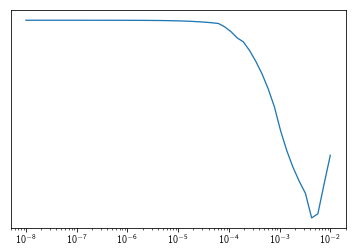

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.004291934260128779, lambda=1.0)!
status 0: Optimization terminated successfully.
145 / 30000 iterations
applying cutoff
... took 19.15576934290584 seconds
(g,i)=(2,8) ...
find hyperparameter


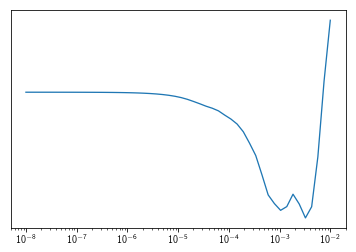

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.00323745754281764, lambda=1.0)!
status 0: Optimization terminated successfully.
163 / 30000 iterations
applying cutoff
... took 21.560103010968305 seconds
(g,i)=(2,9) ...
find hyperparameter


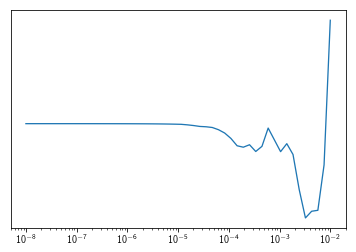

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.00323745754281764, lambda=1.0)!
status 0: Optimization terminated successfully.
162 / 30000 iterations
applying cutoff
... took 21.347071035997942 seconds
(g,i)=(5,0) ...
find hyperparameter


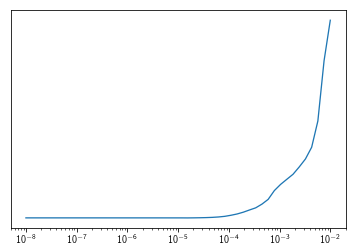

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1.5264179671752335e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
297 / 30000 iterations
applying cutoff
... took 37.78371711296495 seconds
(g,i)=(5,1) ...
find hyperparameter


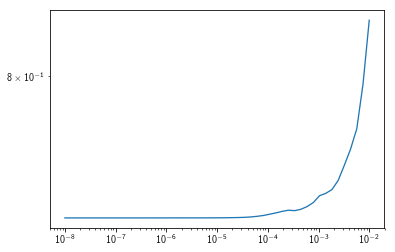

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
293 / 30000 iterations
applying cutoff
... took 36.79847445699852 seconds
(g,i)=(5,2) ...
find hyperparameter


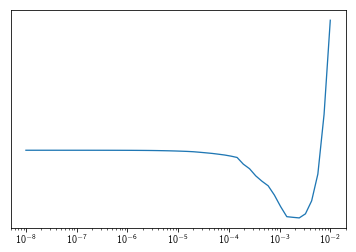

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.0024420530945486497, lambda=1.0)!
status 0: Optimization terminated successfully.
187 / 30000 iterations
applying cutoff
... took 24.367981462040916 seconds
(g,i)=(5,3) ...
find hyperparameter


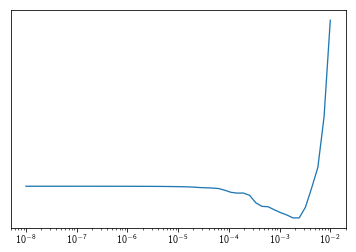

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.0018420699693267163, lambda=1.0)!
status 0: Optimization terminated successfully.
193 / 30000 iterations
applying cutoff
... took 24.967134164995514 seconds
(g,i)=(5,4) ...
find hyperparameter


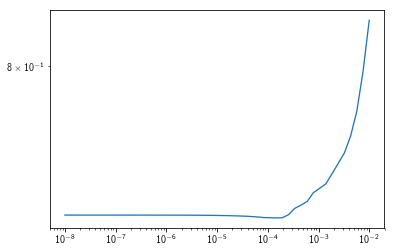

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.00014563484775012445, lambda=1.0)!
status 0: Optimization terminated successfully.
274 / 30000 iterations
applying cutoff
... took 34.85725814208854 seconds
(g,i)=(5,5) ...
find hyperparameter


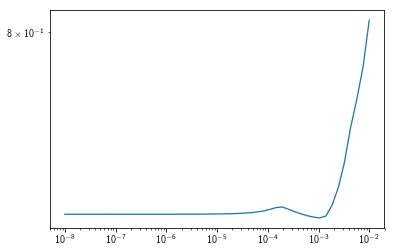

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.0010481131341546852, lambda=1.0)!
status 0: Optimization terminated successfully.
209 / 30000 iterations
applying cutoff
... took 26.924902610946447 seconds
(g,i)=(5,6) ...
find hyperparameter


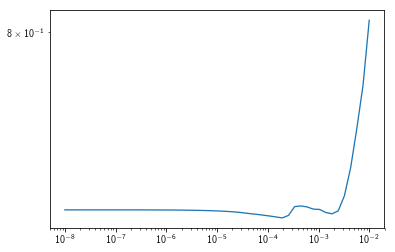

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.00019306977288832496, lambda=1.0)!
status 0: Optimization terminated successfully.
274 / 30000 iterations
applying cutoff
... took 34.79685727902688 seconds
(g,i)=(5,7) ...
find hyperparameter


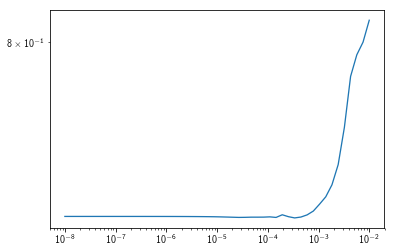

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.000339322177189533, lambda=1.0)!
status 0: Optimization terminated successfully.
261 / 30000 iterations
applying cutoff
... took 33.53381189506035 seconds
(g,i)=(5,8) ...
find hyperparameter


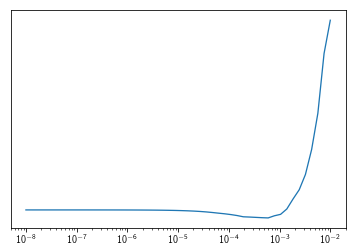

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.0005963623316594637, lambda=1.0)!
status 0: Optimization terminated successfully.
232 / 30000 iterations
applying cutoff
... took 29.794590022997 seconds
(g,i)=(5,9) ...
find hyperparameter


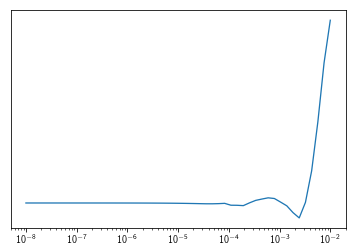

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.0024420530945486497, lambda=1.0)!
status 0: Optimization terminated successfully.
169 / 30000 iterations
applying cutoff
... took 22.07182590593584 seconds
(g,i)=(10,0) ...
find hyperparameter


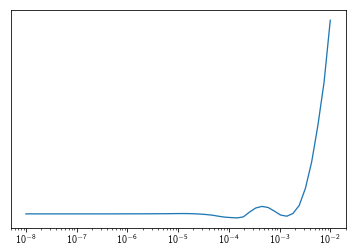

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.00014563484775012445, lambda=1.0)!
status 0: Optimization terminated successfully.
307 / 30000 iterations
applying cutoff
... took 38.52259670896456 seconds
(g,i)=(10,1) ...
find hyperparameter


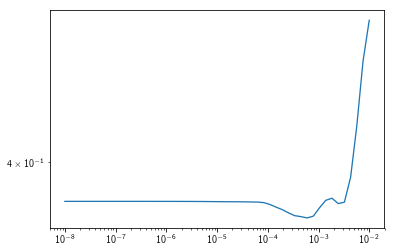

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.0005963623316594637, lambda=1.0)!
status 0: Optimization terminated successfully.
259 / 30000 iterations
applying cutoff
... took 33.705039807013236 seconds
(g,i)=(10,2) ...
find hyperparameter


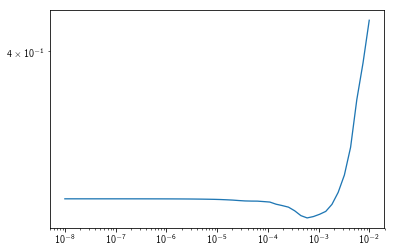

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.0005963623316594637, lambda=1.0)!
status 0: Optimization terminated successfully.
219 / 30000 iterations
applying cutoff
... took 28.048708921996877 seconds
(g,i)=(10,3) ...
find hyperparameter


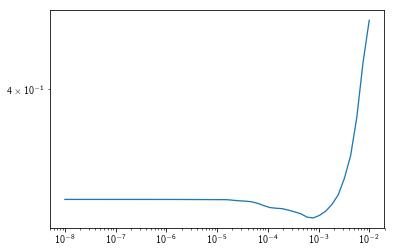

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.0007906043210907702, lambda=1.0)!
status 0: Optimization terminated successfully.
212 / 30000 iterations
applying cutoff
... took 27.181445934111252 seconds
(g,i)=(10,4) ...
find hyperparameter


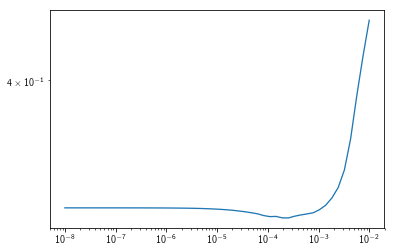

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.00025595479226995333, lambda=1.0)!
status 0: Optimization terminated successfully.
289 / 30000 iterations
applying cutoff
... took 36.70016248500906 seconds
(g,i)=(10,5) ...
find hyperparameter


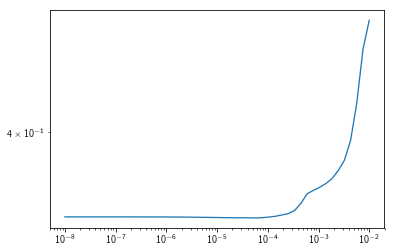

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=4.71486636345739e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
317 / 30000 iterations
applying cutoff
... took 39.74507015408017 seconds
(g,i)=(10,6) ...
find hyperparameter


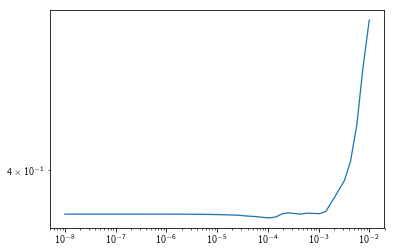

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.00010985411419875573, lambda=1.0)!
status 0: Optimization terminated successfully.
295 / 30000 iterations
applying cutoff
... took 37.515272545977496 seconds
(g,i)=(10,7) ...
find hyperparameter


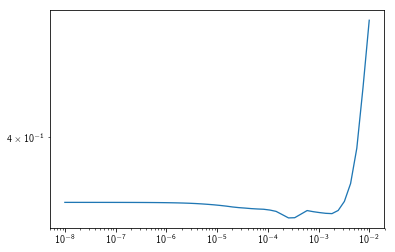

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.00025595479226995333, lambda=1.0)!
status 0: Optimization terminated successfully.
297 / 30000 iterations
applying cutoff
... took 36.4034192309482 seconds
(g,i)=(10,8) ...
find hyperparameter


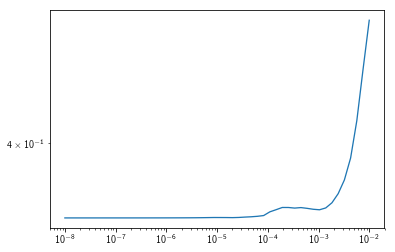

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
309 / 30000 iterations
applying cutoff
... took 39.226286181015894 seconds
(g,i)=(10,9) ...
find hyperparameter


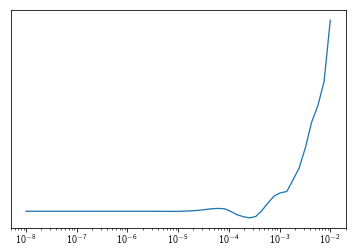

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.00025595479226995333, lambda=1.0)!
status 0: Optimization terminated successfully.
288 / 30000 iterations
applying cutoff
... took 36.747418773011304 seconds
(g,i)=(20,0) ...
find hyperparameter


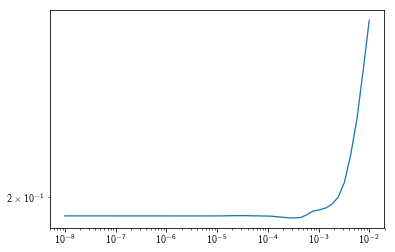

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.000339322177189533, lambda=1.0)!
status 0: Optimization terminated successfully.
261 / 30000 iterations
applying cutoff
... took 33.21114155091345 seconds
(g,i)=(20,1) ...
find hyperparameter


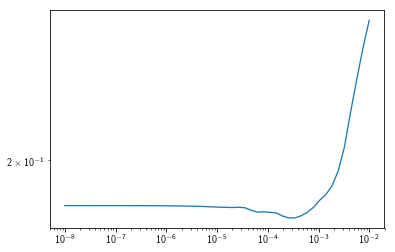

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.000339322177189533, lambda=1.0)!
status 0: Optimization terminated successfully.
284 / 30000 iterations
applying cutoff
... took 36.243859943933785 seconds
(g,i)=(20,2) ...
find hyperparameter


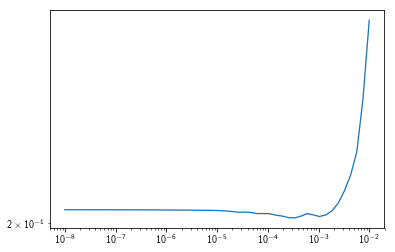

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.000339322177189533, lambda=1.0)!
status 0: Optimization terminated successfully.
274 / 30000 iterations
applying cutoff
... took 34.80930406705011 seconds
(g,i)=(20,3) ...
find hyperparameter


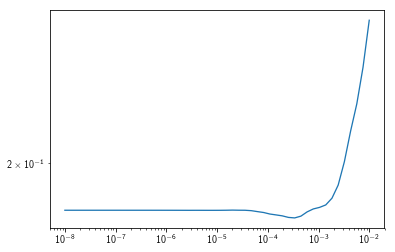

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.000339322177189533, lambda=1.0)!
status 0: Optimization terminated successfully.
261 / 30000 iterations
applying cutoff
... took 33.29257609997876 seconds
(g,i)=(20,4) ...
find hyperparameter


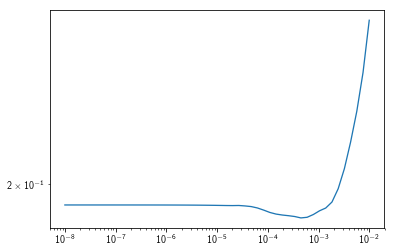

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.0004498432668969444, lambda=1.0)!
status 0: Optimization terminated successfully.
253 / 30000 iterations
applying cutoff
... took 31.99103245290462 seconds
(g,i)=(20,5) ...
find hyperparameter


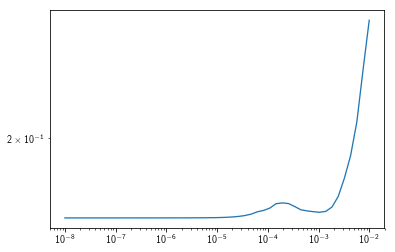

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
365 / 30000 iterations
applying cutoff
... took 46.05731581803411 seconds
(g,i)=(20,6) ...
find hyperparameter


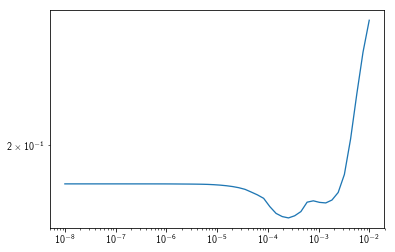

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.00025595479226995333, lambda=1.0)!
status 0: Optimization terminated successfully.
290 / 30000 iterations
applying cutoff
... took 37.08041180798318 seconds
(g,i)=(20,7) ...
find hyperparameter


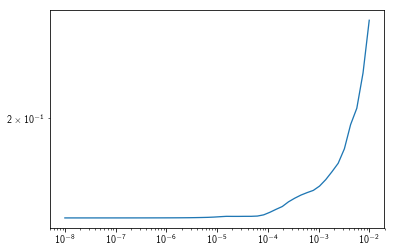

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
356 / 30000 iterations
applying cutoff
... took 44.41003105696291 seconds
(g,i)=(20,8) ...
find hyperparameter


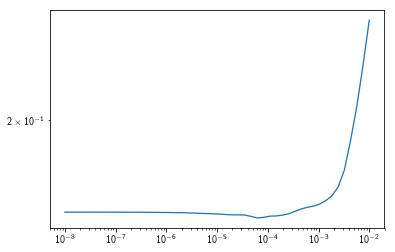

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=6.250551925273976e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
325 / 30000 iterations
applying cutoff
... took 40.93936475797091 seconds
(g,i)=(20,9) ...
find hyperparameter


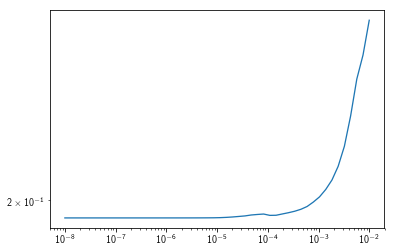

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
348 / 30000 iterations
applying cutoff
... took 43.38801896898076 seconds
(g,i)=(50,0) ...
find hyperparameter


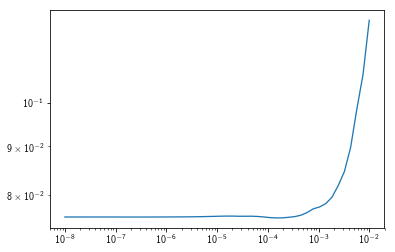

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.00014563484775012445, lambda=1.0)!
status 0: Optimization terminated successfully.
297 / 30000 iterations
applying cutoff
... took 37.59429125802126 seconds
(g,i)=(50,1) ...
find hyperparameter


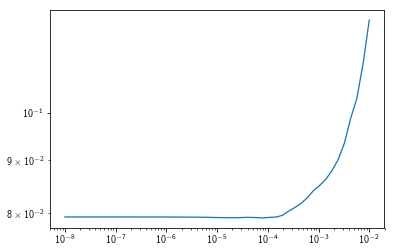

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=8.286427728546843e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
322 / 30000 iterations
applying cutoff
... took 40.39658578496892 seconds
(g,i)=(50,2) ...
find hyperparameter


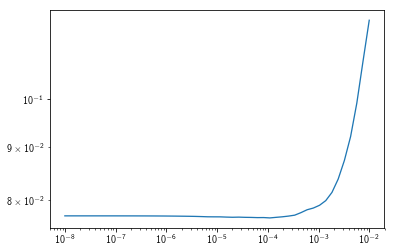

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.00010985411419875573, lambda=1.0)!
status 0: Optimization terminated successfully.
342 / 30000 iterations
applying cutoff
... took 43.036570035037585 seconds
(g,i)=(50,3) ...
find hyperparameter


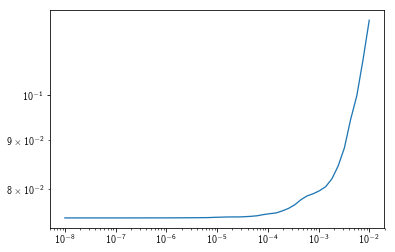

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
370 / 30000 iterations
applying cutoff
... took 46.359220631071366 seconds
(g,i)=(50,4) ...
find hyperparameter


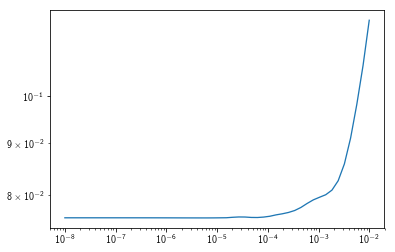

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=4.941713361323839e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
380 / 30000 iterations
applying cutoff
... took 48.35696848598309 seconds
(g,i)=(50,5) ...
find hyperparameter


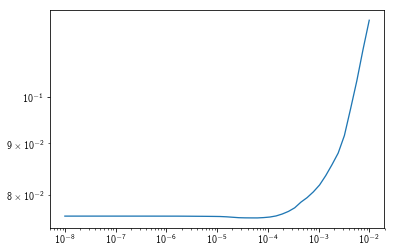

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=6.250551925273976e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
353 / 30000 iterations
applying cutoff
... took 44.48036032204982 seconds
(g,i)=(50,6) ...
find hyperparameter


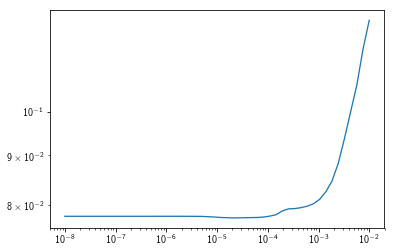

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=2.0235896477251556e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
376 / 30000 iterations
applying cutoff
... took 47.080919348984025 seconds
(g,i)=(50,7) ...
find hyperparameter


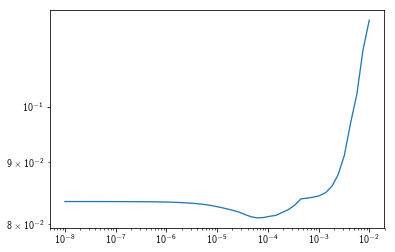

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=6.250551925273976e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
352 / 30000 iterations
applying cutoff
... took 44.526999258901924 seconds
(g,i)=(50,8) ...
find hyperparameter


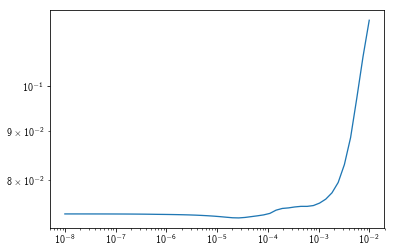

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=2.6826957952797274e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
336 / 30000 iterations
applying cutoff
... took 43.26856306602713 seconds
(g,i)=(50,9) ...
find hyperparameter


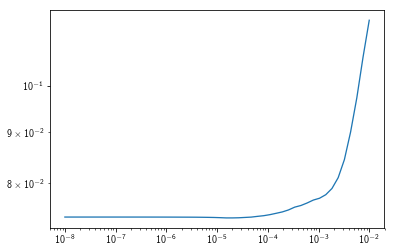

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1.5264179671752335e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
366 / 30000 iterations
applying cutoff
... took 45.856572763994336 seconds
(g,i)=(100,0) ...
find hyperparameter


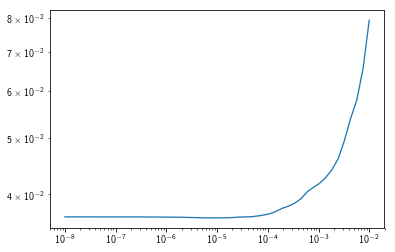

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=8.68511373751352e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
384 / 30000 iterations
applying cutoff
... took 48.161975763970986 seconds
(g,i)=(100,1) ...
find hyperparameter


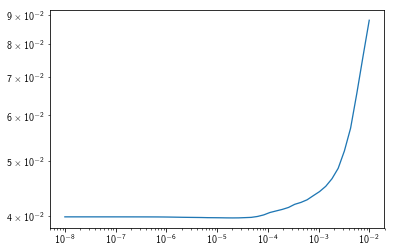

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=2.0235896477251556e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
369 / 30000 iterations
applying cutoff
... took 46.31833244499285 seconds
(g,i)=(100,2) ...
find hyperparameter


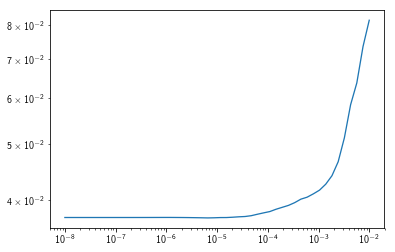

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=6.5512855685955095e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
385 / 30000 iterations
applying cutoff
... took 47.939426091033965 seconds
(g,i)=(100,3) ...
find hyperparameter


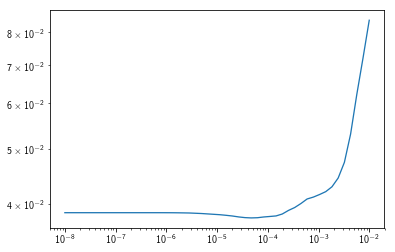

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=4.71486636345739e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
338 / 30000 iterations
applying cutoff
... took 42.55236471106764 seconds
(g,i)=(100,4) ...
find hyperparameter


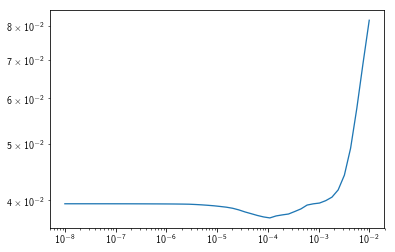

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=0.00010985411419875573, lambda=1.0)!
status 0: Optimization terminated successfully.
320 / 30000 iterations
applying cutoff
... took 40.38965452602133 seconds
(g,i)=(100,5) ...
find hyperparameter


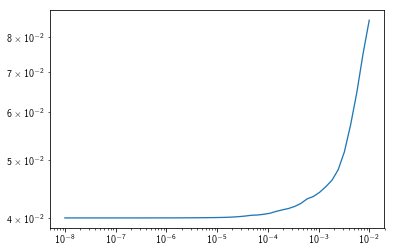

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
398 / 30000 iterations
applying cutoff
... took 48.855104243033566 seconds
(g,i)=(100,6) ...
find hyperparameter


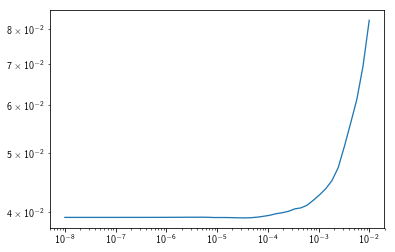

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=3.5564803062231284e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
358 / 30000 iterations
applying cutoff
... took 45.130890836939216 seconds
(g,i)=(100,7) ...
find hyperparameter


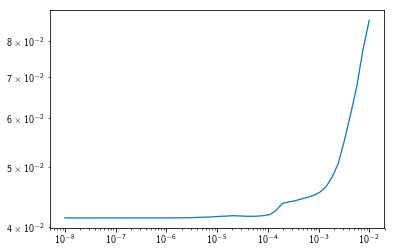

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
375 / 30000 iterations
applying cutoff
... took 46.916890531079844 seconds
(g,i)=(100,8) ...
find hyperparameter


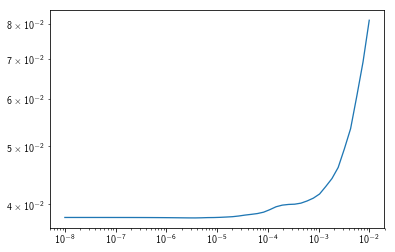

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=3.727593720314938e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
379 / 30000 iterations
applying cutoff
... took 47.09882316796575 seconds
(g,i)=(100,9) ...
find hyperparameter


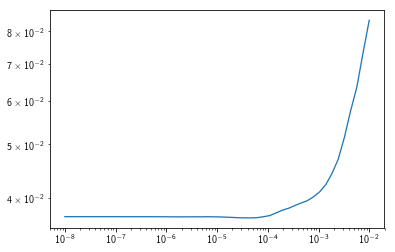

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=4.71486636345739e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
374 / 30000 iterations
applying cutoff
... took 46.909066169988364 seconds
(g,i)=(200,0) ...
find hyperparameter


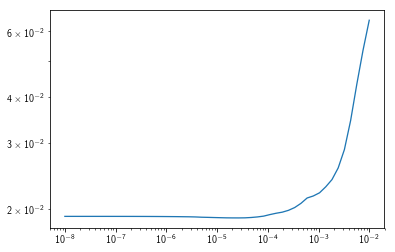

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=2.6826957952797274e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
365 / 30000 iterations
applying cutoff
... took 45.95217328995932 seconds
(g,i)=(200,1) ...
find hyperparameter


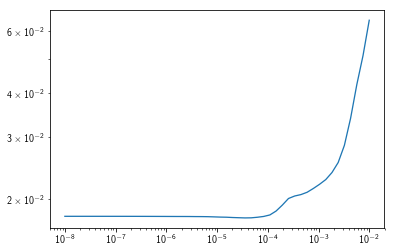

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=3.5564803062231284e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
369 / 30000 iterations
applying cutoff
... took 48.250038205995224 seconds
(g,i)=(200,2) ...
find hyperparameter


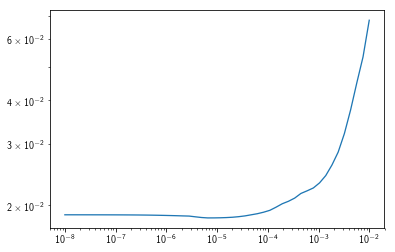

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=6.5512855685955095e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
398 / 30000 iterations
applying cutoff
... took 50.09433077007998 seconds
(g,i)=(200,3) ...
find hyperparameter


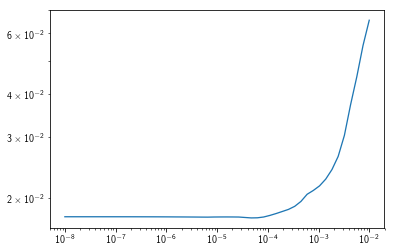

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=4.71486636345739e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
340 / 30000 iterations
applying cutoff
... took 42.98480743600521 seconds
(g,i)=(200,4) ...
find hyperparameter


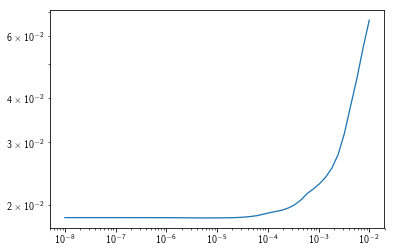

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=6.5512855685955095e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
382 / 30000 iterations
applying cutoff
... took 47.76552795688622 seconds
(g,i)=(200,5) ...
find hyperparameter


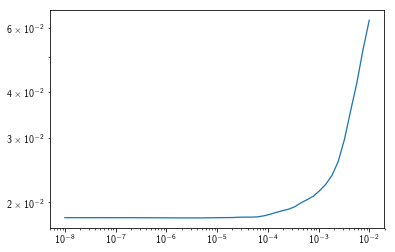

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=3.727593720314938e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
411 / 30000 iterations
applying cutoff
... took 51.49030102498364 seconds
(g,i)=(200,6) ...
find hyperparameter


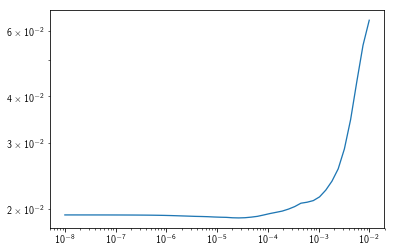

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=2.6826957952797274e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
386 / 30000 iterations
applying cutoff
... took 47.90983317093924 seconds
(g,i)=(200,7) ...
find hyperparameter


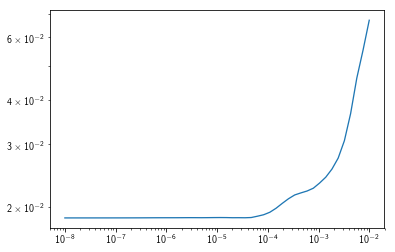

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
396 / 30000 iterations
applying cutoff
... took 50.165848855045624 seconds
(g,i)=(200,8) ...
find hyperparameter


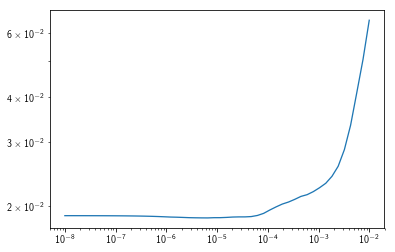

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=6.5512855685955095e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
376 / 30000 iterations
applying cutoff
... took 47.122447603032924 seconds
(g,i)=(200,9) ...
find hyperparameter


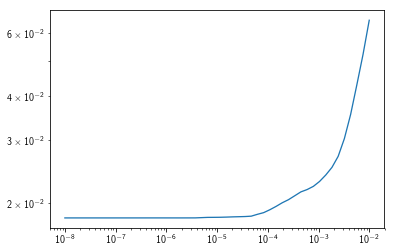

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
394 / 30000 iterations
applying cutoff
... took 49.644044124986976 seconds
(g,i)=(500,0) ...
find hyperparameter


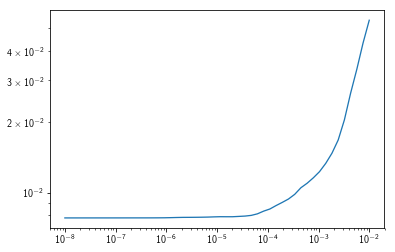

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
428 / 30000 iterations
applying cutoff
... took 53.62861876108218 seconds
(g,i)=(500,1) ...
find hyperparameter


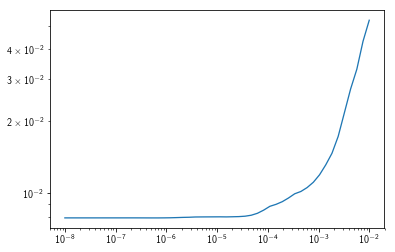

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=5.179474679231213e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
417 / 30000 iterations
applying cutoff
... took 52.028700580005534 seconds
(g,i)=(500,2) ...
find hyperparameter


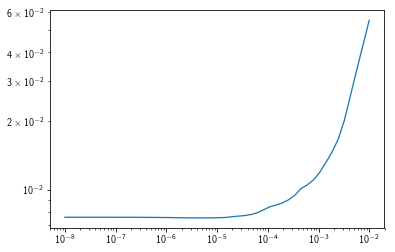

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=4.941713361323839e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
400 / 30000 iterations
applying cutoff
... took 50.195584676926956 seconds
(g,i)=(500,3) ...
find hyperparameter


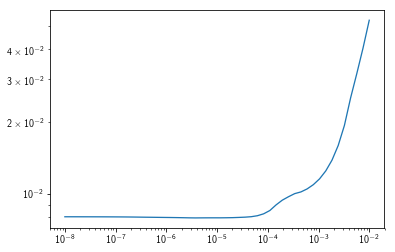

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=3.727593720314938e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
399 / 30000 iterations
applying cutoff
... took 49.63615430390928 seconds
(g,i)=(500,4) ...
find hyperparameter


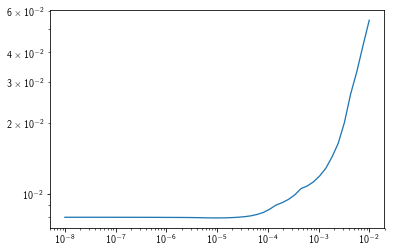

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=8.68511373751352e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
388 / 30000 iterations
applying cutoff
... took 48.80192711902782 seconds
(g,i)=(500,5) ...
find hyperparameter


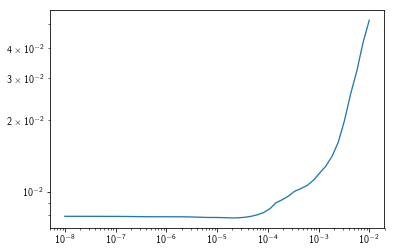

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=2.0235896477251556e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
378 / 30000 iterations
applying cutoff
... took 47.279475350049324 seconds
(g,i)=(500,6) ...
find hyperparameter


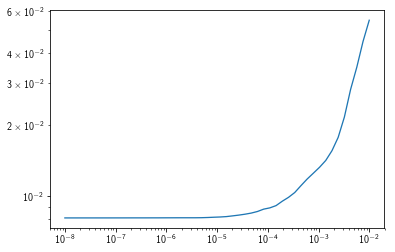

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
431 / 30000 iterations
applying cutoff
... took 54.13947445701342 seconds
(g,i)=(500,7) ...
find hyperparameter


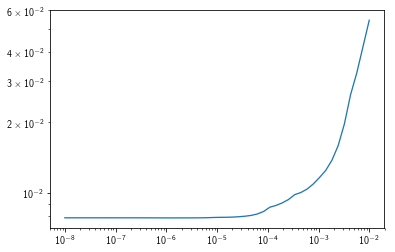

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1.2067926406393288e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
400 / 30000 iterations
applying cutoff
... took 51.016722110915 seconds
(g,i)=(500,8) ...
find hyperparameter


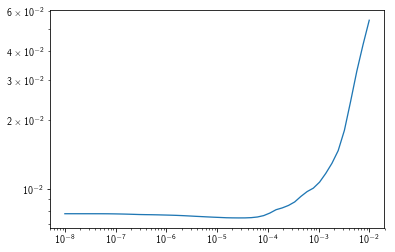

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=2.6826957952797274e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
371 / 30000 iterations
applying cutoff
... took 45.39921910397243 seconds
(g,i)=(500,9) ...
find hyperparameter


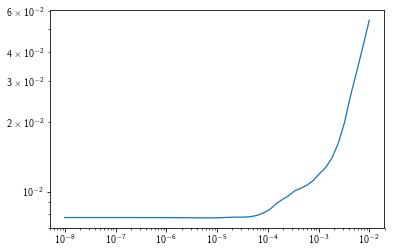

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=6.5512855685955095e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
395 / 30000 iterations
applying cutoff
... took 49.57515067292843 seconds
(g,i)=(1000,0) ...
find hyperparameter


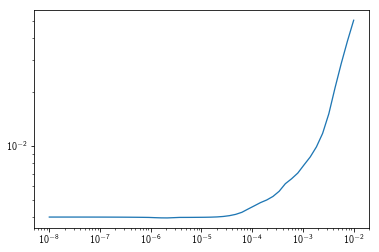

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=2.1209508879201924e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
404 / 30000 iterations
applying cutoff
... took 50.634324674960226 seconds
(g,i)=(1000,1) ...
find hyperparameter


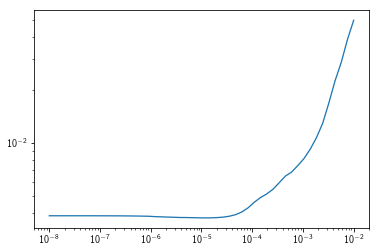

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1.1513953993264481e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
379 / 30000 iterations
applying cutoff
... took 52.10882140696049 seconds
(g,i)=(1000,2) ...
find hyperparameter


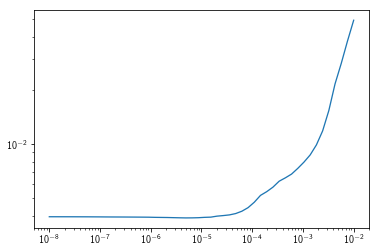

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=4.941713361323839e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
409 / 30000 iterations
applying cutoff
... took 50.404724485008046 seconds
(g,i)=(1000,3) ...
find hyperparameter


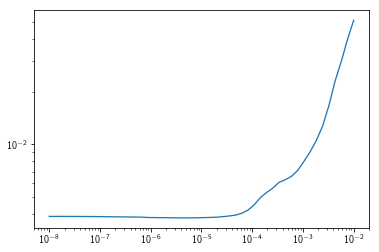

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=3.727593720314938e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
392 / 30000 iterations
applying cutoff
... took 44.77239788102452 seconds
(g,i)=(1000,4) ...
find hyperparameter


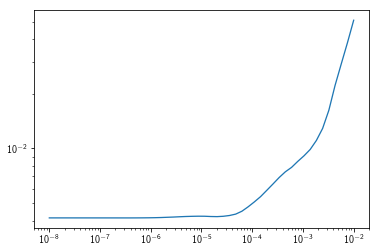

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=3.906939937054621e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
421 / 30000 iterations
applying cutoff
... took 47.69801546796225 seconds
(g,i)=(1000,5) ...
find hyperparameter


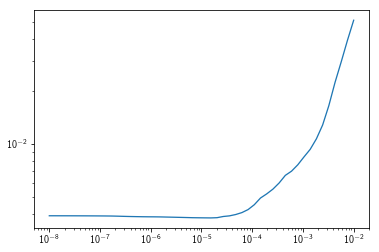

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1.5264179671752335e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
389 / 30000 iterations
applying cutoff
... took 46.08918197802268 seconds
(g,i)=(1000,6) ...
find hyperparameter


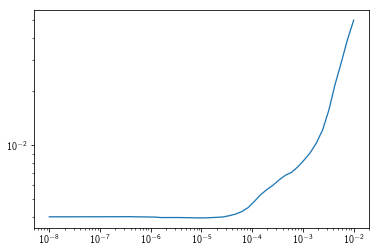

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=8.68511373751352e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
408 / 30000 iterations
applying cutoff
... took 51.02187006501481 seconds
(g,i)=(1000,7) ...
find hyperparameter


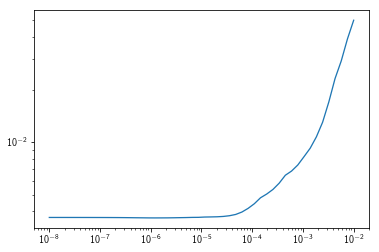

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1.2067926406393288e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
417 / 30000 iterations
applying cutoff
... took 52.20227726001758 seconds
(g,i)=(1000,8) ...
find hyperparameter


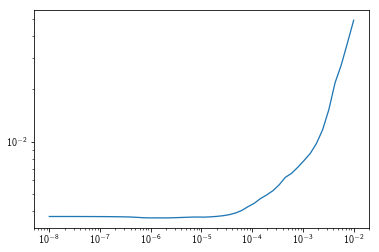

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1.5998587196060574e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
428 / 30000 iterations
applying cutoff
... took 53.913462796015665 seconds
(g,i)=(1000,9) ...
find hyperparameter


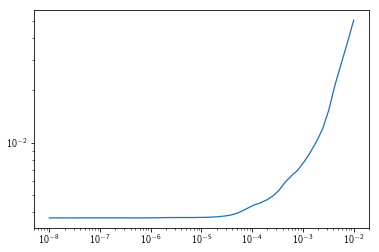

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
417 / 30000 iterations
applying cutoff
... took 52.40724392188713 seconds
(g,i)=(2000,0) ...
find hyperparameter


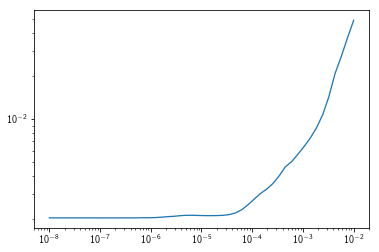

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1.2648552168552957e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
418 / 30000 iterations
applying cutoff
... took 52.44316030503251 seconds
(g,i)=(2000,1) ...
find hyperparameter


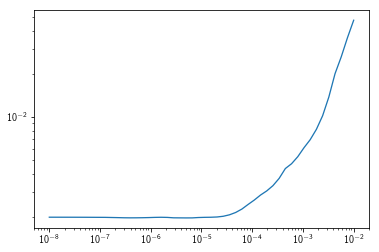

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=4.941713361323839e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
398 / 30000 iterations
applying cutoff
... took 52.38261854206212 seconds
(g,i)=(2000,2) ...
find hyperparameter


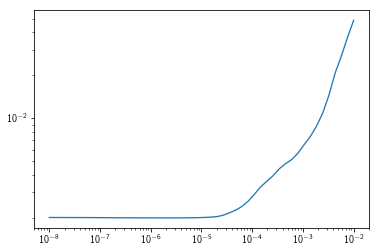

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1.5998587196060574e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
427 / 30000 iterations
applying cutoff
... took 53.43881502409931 seconds
(g,i)=(2000,3) ...
find hyperparameter


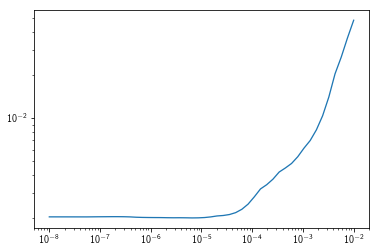

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=6.5512855685955095e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
392 / 30000 iterations
applying cutoff
... took 49.81521927996073 seconds
(g,i)=(2000,4) ...
find hyperparameter


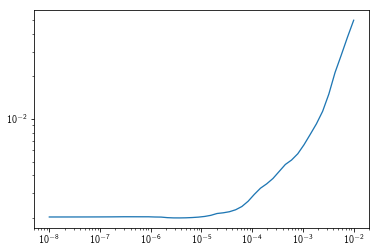

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=3.727593720314938e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
409 / 30000 iterations
applying cutoff
... took 51.909475877997465 seconds
(g,i)=(2000,5) ...
find hyperparameter


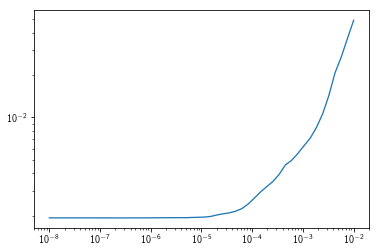

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=2.2229964825261955e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
428 / 30000 iterations
applying cutoff
... took 54.46023334399797 seconds
(g,i)=(2000,6) ...
find hyperparameter


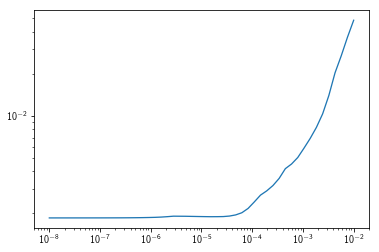

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
420 / 30000 iterations
applying cutoff
... took 53.32874380599242 seconds
(g,i)=(2000,7) ...
find hyperparameter


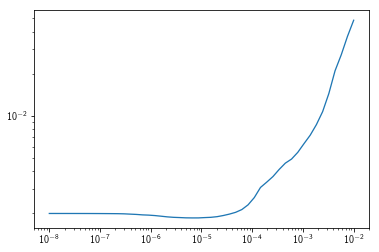

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=6.5512855685955095e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
403 / 30000 iterations
applying cutoff
... took 50.49399561597966 seconds
(g,i)=(2000,8) ...
find hyperparameter


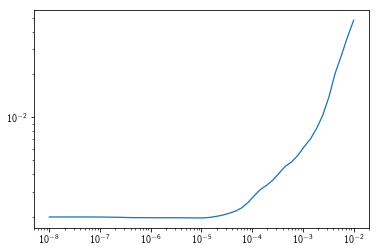

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=8.68511373751352e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
400 / 30000 iterations
applying cutoff
... took 49.920681944000535 seconds
(g,i)=(2000,9) ...
find hyperparameter


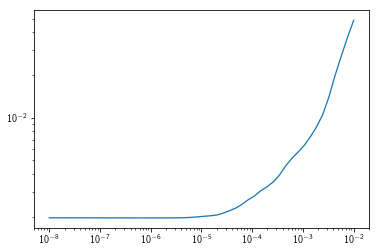

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=5.179474679231213e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
422 / 30000 iterations
applying cutoff
... took 52.96111367503181 seconds
(g,i)=(5000,0) ...
find hyperparameter


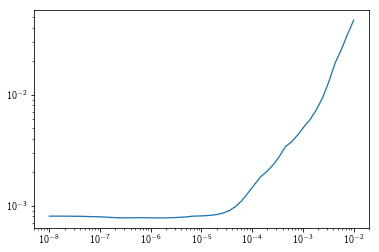

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1.5998587196060574e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
425 / 30000 iterations
applying cutoff
... took 56.295594907947816 seconds
(g,i)=(5000,1) ...
find hyperparameter


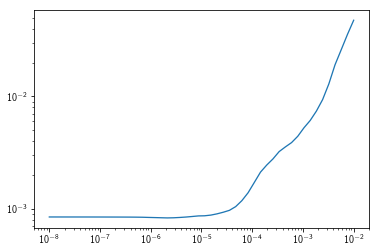

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=2.1209508879201924e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
405 / 30000 iterations
applying cutoff
... took 50.83604112500325 seconds
(g,i)=(5000,2) ...
find hyperparameter


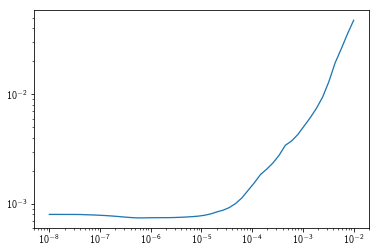

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=6.866488450042998e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
444 / 30000 iterations
applying cutoff
... took 55.16852798499167 seconds
(g,i)=(5000,3) ...
find hyperparameter


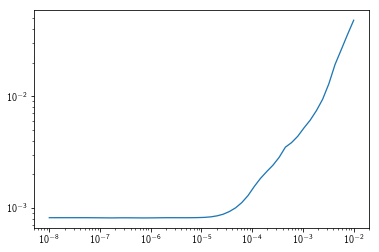

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=6.866488450042998e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
420 / 30000 iterations
applying cutoff
... took 52.58188335096929 seconds
(g,i)=(5000,4) ...
find hyperparameter


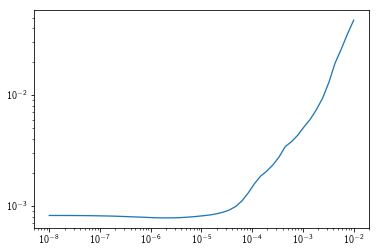

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=2.1209508879201924e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
405 / 30000 iterations
applying cutoff
... took 50.94251428404823 seconds
(g,i)=(5000,5) ...
find hyperparameter


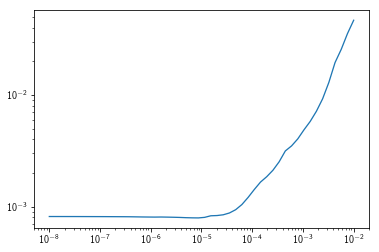

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=8.68511373751352e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
401 / 30000 iterations
applying cutoff
... took 50.510988167021424 seconds
(g,i)=(5000,6) ...
find hyperparameter


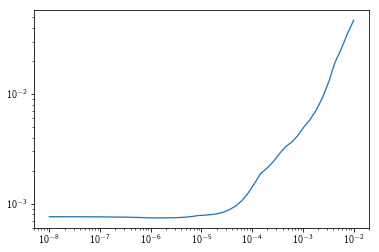

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1.2067926406393288e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
438 / 30000 iterations
applying cutoff
... took 54.918757213046774 seconds
(g,i)=(5000,7) ...
find hyperparameter


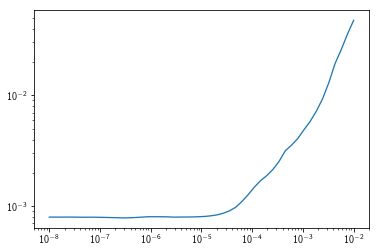

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=2.94705170255181e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
439 / 30000 iterations
applying cutoff
... took 55.10253053694032 seconds
(g,i)=(5000,8) ...
find hyperparameter


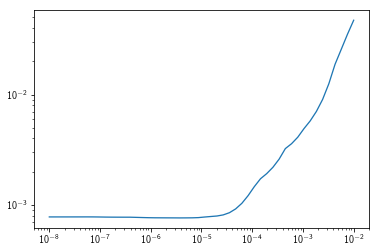

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=3.727593720314938e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
414 / 30000 iterations
applying cutoff
... took 51.627285947906785 seconds
(g,i)=(5000,9) ...
find hyperparameter


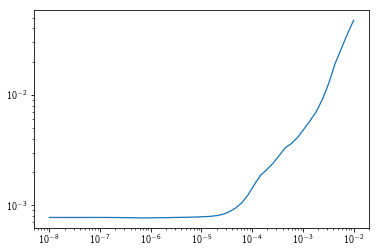

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=6.866488450042998e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
437 / 30000 iterations
applying cutoff
... took 55.701437780982815 seconds
(g,i)=(10000,0) ...
find hyperparameter


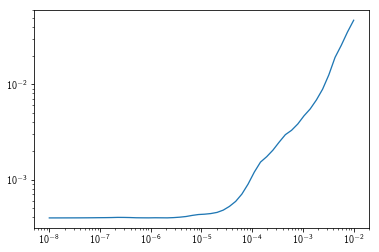

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
453 / 30000 iterations
applying cutoff
... took 57.56102861999534 seconds
(g,i)=(10000,1) ...
find hyperparameter


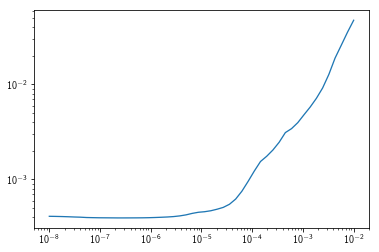

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=2.2229964825261955e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
457 / 30000 iterations
applying cutoff
... took 56.08700138493441 seconds
(g,i)=(10000,2) ...
find hyperparameter


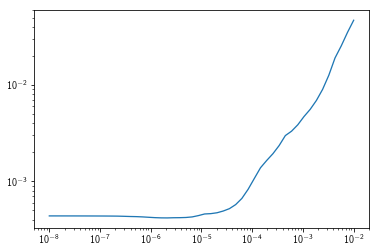

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=2.1209508879201924e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
427 / 30000 iterations
applying cutoff
... took 53.388937297975644 seconds
(g,i)=(10000,3) ...
find hyperparameter


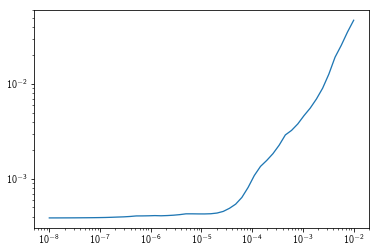

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
441 / 30000 iterations
applying cutoff
... took 59.90187248797156 seconds
(g,i)=(10000,4) ...
find hyperparameter


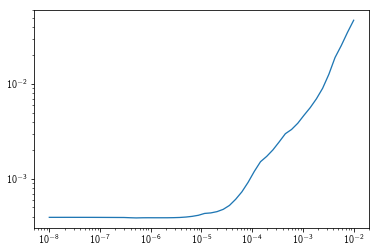

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=5.179474679231213e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
437 / 30000 iterations
applying cutoff
... took 54.954184415983036 seconds
(g,i)=(10000,5) ...
find hyperparameter


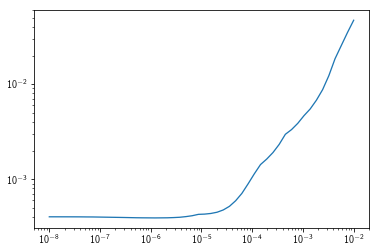

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1.2067926406393288e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
416 / 30000 iterations
applying cutoff
... took 53.11000515706837 seconds
(g,i)=(10000,6) ...
find hyperparameter


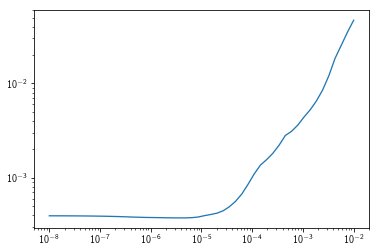

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=3.727593720314938e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
410 / 30000 iterations
applying cutoff
... took 50.90660076402128 seconds
(g,i)=(10000,7) ...
find hyperparameter


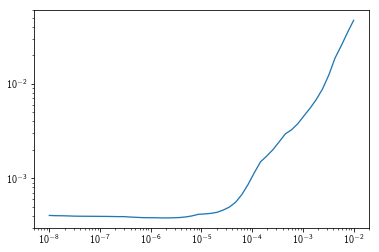

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=2.1209508879201924e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
411 / 30000 iterations
applying cutoff
... took 51.52648677304387 seconds
(g,i)=(10000,8) ...
find hyperparameter


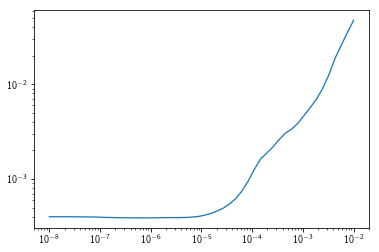

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=9.102981779915227e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
424 / 30000 iterations
applying cutoff
... took 53.18392052699346 seconds
(g,i)=(10000,9) ...
find hyperparameter


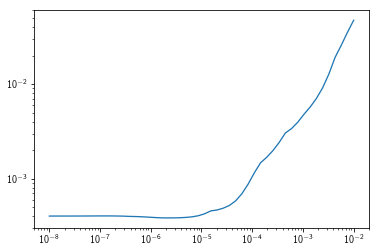

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=2.1209508879201924e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
417 / 30000 iterations
applying cutoff
... took 51.81166394997854 seconds
(g,i)=(20000,0) ...
find hyperparameter


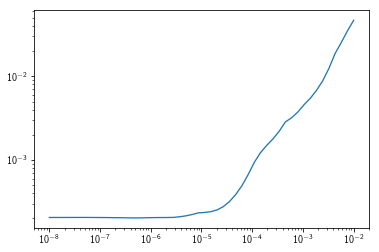

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=5.179474679231213e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
438 / 30000 iterations
applying cutoff
... took 55.09027792408597 seconds
(g,i)=(20000,1) ...
find hyperparameter


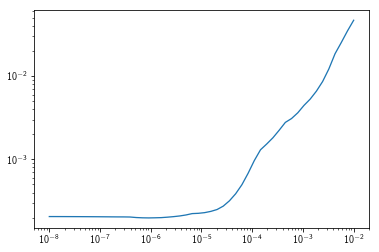

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=9.102981779915227e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
410 / 30000 iterations
applying cutoff
... took 51.35111114301253 seconds
(g,i)=(20000,2) ...
find hyperparameter


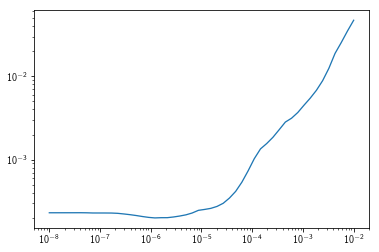

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1.2067926406393288e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
425 / 30000 iterations
applying cutoff
... took 54.529734824900515 seconds
(g,i)=(20000,3) ...
find hyperparameter


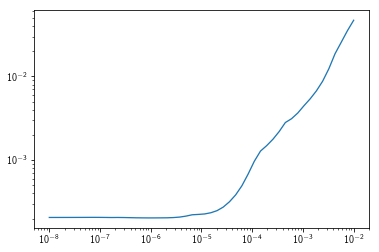

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=9.102981779915227e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
432 / 30000 iterations
applying cutoff
... took 54.245785627979785 seconds
(g,i)=(20000,4) ...
find hyperparameter


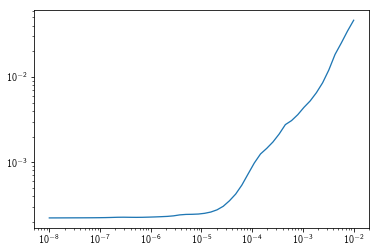

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
444 / 30000 iterations
applying cutoff
... took 55.78205756295938 seconds
(g,i)=(20000,5) ...
find hyperparameter


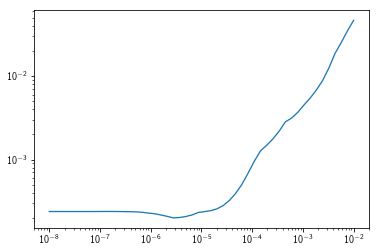

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=2.811768697974231e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
407 / 30000 iterations
applying cutoff
... took 51.146564557100646 seconds
(g,i)=(20000,6) ...
find hyperparameter


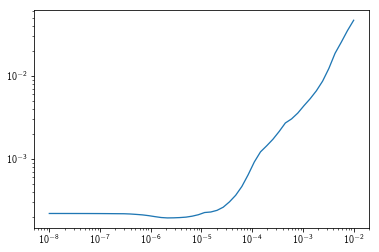

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=2.1209508879201924e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
422 / 30000 iterations
applying cutoff
... took 53.02417308499571 seconds
(g,i)=(20000,7) ...
find hyperparameter


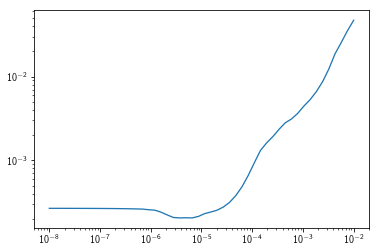

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=6.5512855685955095e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
412 / 30000 iterations
applying cutoff
... took 51.69950380898081 seconds
(g,i)=(20000,8) ...
find hyperparameter


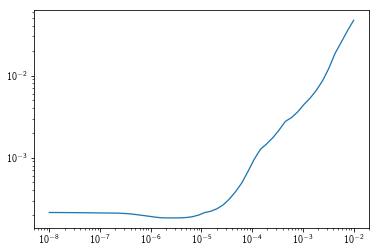

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=2.811768697974231e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
416 / 30000 iterations
applying cutoff
... took 51.95387812098488 seconds
(g,i)=(20000,9) ...
find hyperparameter


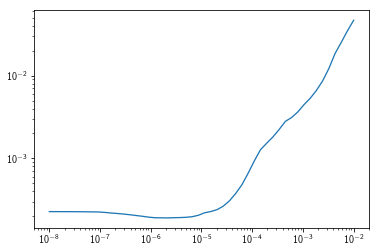

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
optimization problem did exit successfully (alpha=2.1209508879201924e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
419 / 30000 iterations
applying cutoff
... took 52.50138518598396 seconds


In [27]:
estimated_rates = dict()
l1_err = dict()
used_alphas = dict()
for g in gillespie_realisations:
    cv_res_g = cv_results[cv_results.gillespie_realisations == g]
    estimated_rates[g] = dict() 
    l1_err[g] = dict()
    used_alphas[g] = dict()
    for i in iids:
        print("(g,i)=({},{}) ...".format(g, i))
        
        print("find hyperparameter")
        cv_res = cv_res_g[cv_res_g.iid == i]
        cv_res = cv_res.sort_values(by="alpha")
        current_alphas = np.array([x for x in cv_res.alpha.values])
        #current_scores = np.array([x for x in cv_res.scores.values])[:,4] # use only 4th fold
        current_scores = np.array([x for x in cv_res.scores.values])[:,1:] # use all except first and average
        current_scores = np.mean(current_scores, axis=1) # average over folds
        #print(current_alphas)
        #print(current_scores)
        min_indices = np.argmin(-current_scores, axis=0)
        optimal_alpha = alphas[min_indices]
        used_alphas[g][i] = optimal_alpha
        plt.plot(current_alphas, -current_scores)
        plt.xscale("log")
        plt.yscale("log")
        plt.show()
        t1 = time.perf_counter()
        
        print("estimating model")
        rates, analyse = rs.estimate(alpha=optimal_alpha, gillespie_realisations=g, iid_id=i)
        
        print("applying cutoff")
        rates[rates < 0.38] = 0.
        
        estimated_rates[g][i] = rates
        l1_err[g][i] = np.sum(np.abs(rates-desired_rates))
        t2 = time.perf_counter()
        print("... took {} seconds".format(t2-t1))

In [28]:
rates_arr = np.array([ [estimated_rates[g][i] for i in iids] for g in gillespie_realisations])
l1_err_arr = np.array([ [l1_err[g][i] for i in iids] for g in gillespie_realisations])
used_alphas_arr = np.array([ [used_alphas[g][i] for i in iids] for g in gillespie_realisations])

In [29]:
if True:
    np.savez("case2_validation_alphas_and_solutions_averagefolds.npz", rates=rates_arr, l1_dev=l1_err_arr, alpha_val=used_alphas_arr)

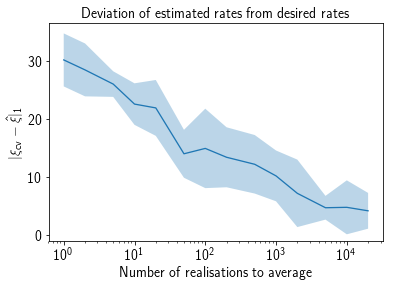

In [30]:
plt.style.use("lm")
mean = np.mean(l1_err_arr, axis=1)
err = np.std(l1_err_arr, axis=1) #/ np.sqrt(10.) # 10 iids
plt.plot(gillespie_realisations, mean)
plt.fill_between(gillespie_realisations, y1=np.clip(mean-err, 0., 1e16), y2=mean+err, alpha=0.3)
plt.xscale("log")
plt.xlabel("Number of realisations to average")
plt.ylabel(r"$|\xi_\mathrm{cv}-\hat{\xi}|_1$")
plt.title("Deviation of estimated rates from desired rates")
ymin, ymax = plt.ylim()
plt.ylim(-1,ymax)
plt.savefig("case2_convergence_averagefolds.pdf", bbox_inches="tight", transparent=True)

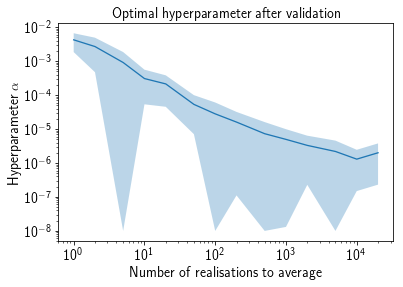

In [31]:

mean = np.mean(used_alphas_arr, axis=1)
err = np.std(used_alphas_arr, axis=1) #/ np.sqrt(10.) # 10 iids
plt.plot(gillespie_realisations, mean)
plt.fill_between(gillespie_realisations, y1=np.clip(mean-err, 1e-8, 1.), y2=mean+err, alpha=0.3)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of realisations to average")
plt.ylabel(r"Hyperparameter $\alpha$")
plt.title("Optimal hyperparameter after validation")
#ymin, ymax = plt.ylim()
#plt.ylim(-1,ymax)
plt.savefig("case2_best_hyperparameter_averagefolds.pdf", bbox_inches="tight", transparent=True)

20000


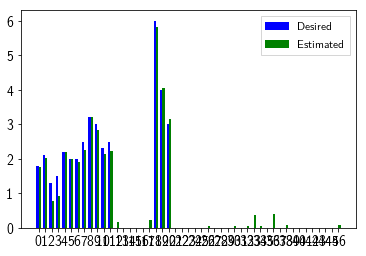

In [32]:
g_idx = -1
i_idx = 3
print(gillespie_realisations[g_idx])
analysis.plot_rates_bar(desired_rates, np.mean(rates_arr[g_idx], axis=0))

#plt.savefig("case2_exemplary_solution_n"+str(gillespie_realisations[g_idx])+".pdf", bbox_inches="tight", transparent=True)